In [2]:
using RCall, DataFrames, LogTopReg, Distributions
import Lazy.@>, Lazy.@>>


Attaching package: ‘dplyr’

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Stackoverflow is a great place to get help:
http://stackoverflow.com/tags/ggplot2.
data.table 1.10.0
  The fastest way to learn (by data.table authors): https://www.datacamp.com/courses/data-analysis-the-data-table-way
  Documentation: ?data.table, example(data.table) and browseVignettes("data.table")
  Release notes, videos and slides: http://r-datatable.com

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last



In [3]:
using LogTopReg
include("../juliafromR.jl");
Y,X,pss0 = getfocaldata();

  Bumped column 5 to type character on data row 6913, field contains '208B0'. Coercing previously read values in this column from logical, integer or numeric back to character which may not be lossless; e.g., if '00' and '000' occurred before they will now be just '0', and there may be inconsistencies with treatment of ',,' and ',NA,' too (if they occurred in this column before the bump). If this matters please rerun and set 'colClasses' to 'character' for this column. Please note that column type detection uses a sample of 1,000 rows (100 rows at 10 points) so hopefully this message should be very rare. If reporting to datatable-help, please rerun and include the output from verbose=TRUE.
Warning in fread(files[i]) :
  Bumped column 15 to type character on data row 57995, field contains 'sister'. Coercing previously read values in this column from logical, integer or numeric back to character which may not be lossless; e.g., if '00' and '000' occurred before they will now be just '0',

In [4]:
R"library(rstan)"
R"topetho <- stan_model('~/code/topetho/categorical_topetho.stan')";
R"dat <- list(n=nrow(Y),K=3,B=ncol(Y)-3,Bs=sapply(Y[,-c(1:3),with=F],max),Y=as.matrix(Y[,-c(1:3),with=F]),alpha=1)";

rstan (Version 2.12.1, packaged: 2016-09-11 13:07:50 UTC, GitRev: 85f7a56811da)
For execution on a local, multicore CPU with excess RAM we recommend calling
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())


make: *** [file16cd44cd4acf.o] Interrupt

ERROR(s) during compilation: source code errors or compiler configuration errors!

Program source:
  1: 
  2: // includes from the plugin
  3: 
  4: 
  5: // user includes
  6: #define STAN__SERVICES__COMMAND_HPP// Code generated by Stan version 2.12
  7: 
  8: #include <stan/model/model_header.hpp>
  9: 
 10: namespace model16cd6cc8981d_categorical_topetho_namespace {
 11: 
 12: using std::istream;
 13: using std::string;
 14: using std::stringstream;
 15: using std::vector;
 16: using stan::io::dump;
 17: using stan::math::lgamma;
 18: using stan::model::prob_grad;
 19: using namespace stan::math;
 20: 
 21: typedef Eigen::Matrix<double,Eigen::Dynamic,1> vector_d;
 22: typedef Eigen::Matrix<double,1,Eigen::Dynamic> row_vector_d;
 23: typedef Eigen::Matrix<double,Eigen::Dynamic,Eigen::Dynamic> matrix_d;
 24: 
 25: static int current_statement_begin__;
 26: 
 27: class model16cd6cc8981d_categorical_topetho : public prob_grad {
 28: private:
 29

LoadError: LoadError: RCall.jl: Warning: running command '/usr/lib/R/bin/R CMD SHLIB file16cd44cd4acf.cpp 2> file16cd44cd4acf.cpp.err.txt' had status 1
Error in compileCode(f, code, language = language, verbose = verbose) : 
  Compilation ERROR, function(s)/method(s) not created! make: *** [file16cd44cd4acf.o] Interrupt

while loading In[4], in expression starting on line 79

In [4]:
runs = 10;
ll = Vector{Float64}(runs);
r = Vector{Array{Float64,2}}(runs);
for i in 1:runs
    R"optout <- optimizing(topetho,dat,verbose=F)";
    ll[i] = rcopy(R"optout$value");
    r[i] = rcopy(R"optout$par[str_detect(names(optout$par),'^r\\[')] %>% matrix(nrow=dat$K,ncol=dat$n,byrow = T)")
end

STAN OPTIMIZATION COMMAND (LBFGS)
init = random
save_iterations = 1
init_alpha = 0.001
tol_obj = 1e-12
tol_grad = 1e-08
tol_param = 1e-08
tol_rel_obj = 10000
tol_rel_grad = 1e+07
history_size = 5
seed = 577314241
initial log joint probability = -223827
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
STAN OPTIMIZATION COMMAND (LBFGS)
init = random
save_iterations = 1
init_alpha = 0.001
tol_obj = 1e-12
tol_grad = 1e-08
tol_param = 1e-08
tol_rel_obj = 10000
tol_rel_grad = 1e+07
history_size = 5
seed = 175996696
initial log joint probability = -241726
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
STAN OPTIMIZATION COMMAND (LBFGS)
init = random
save_iterations = 1
init_alpha = 0.001
tol_obj = 1e-12
tol_grad = 1e-08
tol_param = 1e-08
tol_rel_obj = 10000
tol_rel_grad = 1e+07
history_size = 5
seed = 214766971
initial log joint probability = -236752
Optimization terminated norma

In [149]:
r = readcsv("/home/seth/analysis/logtopreg/optimout_FKKR.csv");

In [150]:
zflat = mapslices(x -> rand(Categorical(x)),r,2);
z = Vector{Vector{Int64}}(length(Y));
nd = map(x -> size(x)[2],Y);
guh = 1;
for i in 1:length(Y)
    z[i] = zflat[guh:(guh+nd[i]-1)];
    guh += nd[i];
end

In [151]:
K = 10;
niter = 1000;
thin = 2;
ns = div(niter,thin);

In [16]:
@time fit = simplemix(hcat(Y...),pss0,K,zinit=vcat(z...),iter=niter,thin=thin);

383.047338 seconds (6.17 G allocations: 124.831 GB, 3.21% gc time)


In [152]:
@time fit3 = topiclmm(Y,X,pss0,zinit=z,K,iter=niter,thin=thin);

459.819227 seconds (6.08 G allocations: 139.411 GB, 3.12% gc time)


In [156]:
size(X)

(11,228)

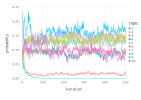

In [157]:
using Gadfly
mudat = DataFrame(probability = mapslices(softmax,fit3[:μ],1)[:],topic=repeat(map(string,1:K),outer=[ns]),
iteration=repeat(collect(1:ns),inner=[K]));
plot(mudat,x="iteration",y="probability",color="topic",Geom.line)

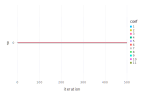

In [146]:
p = size(X)[1];
bdat = DataFrame(β = vec( refβ(fit3[:β],fit3[:μ]) ),
iteration = repeat(collect(1:ns),inner=[K*p]),topic = repeat(map(string,1:K),inner=[p],outer=[ns]),
coef=repeat(map(string,1:p),outer=[K*ns]));
plot(bdat[bdat[:topic].=="5",:],y="β",x="iteration",color="coef",Geom.line)

In [147]:
writefit(fit3,"/home/seth/analysis/logtopreg/fitFKKR_5K/")

In [126]:
params(topicppd(fit3[:topic][10,500])[17])[1]

4-element Array{Float64,1}:
 0.534972 
 0.323251 
 0.128544 
 0.0132325

In [72]:
size(Y[1])

(30,76)